In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import nltk
import spacy
import gensim
from gensim import corpora
pd.set_option("display.max_colwidth", 200)
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import preprocessor as p
from nltk.cluster.util import cosine_distance
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Run this cell only once
nltk.download('stopwords')

In [2]:
from nltk.corpus import stopwords

# Fetching Data Files

In [3]:
#twitter_all_truncated = os.listdir("search_truncated/")
twitter_all_files = os.listdir("search_extended/")
youtube_all_files = os.listdir("youtube_daily/")

In [4]:
# Retrieving data files corresponding to keyword

keyword = 'imran khan'
#twitter_truncated = []
twitter_files = []
youtube_files = []

for file in twitter_all_files:
    if keyword in file:
        twitter_files.append(file)
        
for file in youtube_all_files:
    if keyword in file:
        youtube_files.append(file)

In [15]:
# Loading Twitter JSON files

twitter_json = []

for file in twitter_files:
    with open("search_extended/" + file) as json_file:
        
        # Load file
        data = json.load(json_file)
        
        # Concatenate all files
        twitter_json = twitter_json + data
        
twitter_json[0]

{'created_at': 'Sat Nov 30 23:52:15 +0000 2019',
 'id': 1200925541228064800,
 'id_str': '1200925541228064770',
 'full_text': 'RT @DunyaNews: PM Imran Khan lists down five strategies to cope with smog in Punjab and other parts of the country.\n\n#DunyaUpdates #DunyaNe…',
 'truncated': False,
 'display_text_range': [0, 140],
 'entities': {'hashtags': [{'text': 'DunyaUpdates', 'indices': [117, 130]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'DunyaNews',
    'name': 'Dunya News',
    'id': 99458922,
    'id_str': '99458922',
    'indices': [3, 13]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 916362400504451100,
  'id_str': '916362400504451072',
  'name': 'kami Khan',
  'scre

In [6]:
# Loading YouTube JSON files

yt_json = []

for file in youtube_files:
    with open("youtube_daily/" + file) as json_file:
        
        # Load file
        data = json.load(json_file)        
        
        # Concatenate all files
        yt_json = yt_json + data
    
yt_json[0]

{'kind': 'youtube#searchResult',
 'etag': '"j6xRRd8dTPVVptg711_CSPADRfg/B4L0LQa_iaUZY8X4YQ5GAq4OJAU"',
 'id': {'kind': 'youtube#video', 'videoId': 'oUffbzy63DE'},
 'snippet': {'publishedAt': '2019-11-24T14:27:57.000Z',
  'channelId': 'UC_vt34wimdCzdkrzVejwX9g',
  'title': 'Norway Ka Waqia Islamophobia Ki Aik Taza Misaal Hey: PM Imran Khan',
  'description': 'Norway Ka Waqia Islamophobia Ki Aik Taza Misaal Hey: PM Imran Khan Watch more videos subscribe - https://www.youtube.com/geonews or Visit our website ...',
  'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/oUffbzy63DE/default.jpg',
    'width': 120,
    'height': 90},
   'medium': {'url': 'https://i.ytimg.com/vi/oUffbzy63DE/mqdefault.jpg',
    'width': 320,
    'height': 180},
   'high': {'url': 'https://i.ytimg.com/vi/oUffbzy63DE/hqdefault.jpg',
    'width': 480,
    'height': 360}},
  'channelTitle': 'Geo News',
  'liveBroadcastContent': 'none'}}

In [16]:
# Retrieving relevant information from the Twitter JSON objects

columns = ['Created_time', 'URL', 'User_name', 'Twitter_handle', 'Description', 'Retweet_count', 'Favorite_count', 'Sentiment', 'Topic']
df_tweets = pd.DataFrame(columns=columns)

for i in range(0, len(twitter_json)):
    
    Created_time = twitter_json[i]['created_at']
    
    URL = 'twitter.com/i/web/status/' + twitter_json[i]['id_str']
    
    User_name = twitter_json[i]['user']['name']
    
    Twitter_handle = twitter_json[i]['user']['screen_name']
    
    if 'retweeted_status' not in twitter_json[i]:
        Description = twitter_json[i]['full_text']
    else:
        Description = twitter_json[i]['retweeted_status']['full_text']
    
    Retweet_count = twitter_json[i]['retweet_count']
    
    Favorite_count = twitter_json[i]['favorite_count']
    
    Sentiment = twitter_json[i]['sentiment']
    
    df_tweets = df_tweets.append({'Created_time':Created_time,'URL':URL,'User_name':User_name,
                                  'Twitter_handle':Twitter_handle,'Description':Description,
                                  'Retweet_count':Retweet_count,'Favorite_count':Favorite_count,
                                  'Sentiment':Sentiment, 'Topic':np.nan}, ignore_index=True)
    
len(df_tweets)

1399

In [8]:
df_tweets.head()

,Created_time,URL,User_name,Twitter_handle,Description,Retweet_count,Favorite_count,Sentiment,Topic
0,Sat Nov 30 23:52:15 +0000 2019,twitter.com/i/web/status/1200925541228064770,kami Khan,saleemkamikhan,PM Imran Khan lists down five strategies to cope with smog in Punjab and other parts of the country.\n\n#DunyaUpdates #DunyaNews #DunyaVideos https://t.co/tQNPcxIVJm,14,0,#ff0000,NaN
1,Sat Nov 30 23:52:03 +0000 2019,twitter.com/i/web/status/1200925489742974976,Irfan Ullah,IrfanUK11,@GulBukhari I just dont understand country was suffering several years because of corrupt politics instead of doing something good for country and people you tweeting and making fun thats really s...,0,1,#8caa0b,NaN
2,Sat Nov 30 23:51:07 +0000 2019,twitter.com/i/web/status/1200925253095972864,Sandy67,Sandy6704253501,#Pakistan Prime Minister #ImranKhan has urged the world to help end curfew in #Kashmir.\n\nThere is no curfew in #Kashmir. Imran Khan should check basic facts before speaking. He always spreads mi...,53,0,#8caa0b,NaN
3,Sat Nov 30 23:50:01 +0000 2019,twitter.com/i/web/status/1200924976511094786,Syyed Farrukh,FarrukhSyyed,Oyee kashmir per trend kerne walon \nOyee imran Khan ki himayat mai awaz uthany walon \nOyeee nawaz sharif ki himayat mai Awaz uthany walon \nOyeee khali peeli mai number barhany walon \nKuch hosh...,0,0,#ff0000,NaN
4,Sat Nov 30 23:49:18 +0000 2019,twitter.com/i/web/status/1200924799297568769,Muzaffar,chinar70,Deadly silence of the world on #Kashmir needs to be called out.\n #StandWithKashmir\n@naomi_long @NatalieSuleyman @NolaMarinoMP @PeterDutton_MP \n#SanctionsForIndia #KashmirReferendum #BoycottInd...,0,0,#ff0000,NaN


In [9]:
# Retrieving relevant information from the Youtube JSON objects

ss=r'([12]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01]))'
columns = ['Published_date', 'Title', 'URL', 'Channel_id', 'Topic']
df_videos = pd.DataFrame(columns=columns)

for i in range(0, len(yt_json)):
    
    Published_date = re.findall(ss,yt_json[i]['snippet']['publishedAt'])[0][0]
    
    Title = yt_json[i]['snippet']['title']
    
    Channel_id = yt_json[i]['snippet']['channelId']
    
    URL = 'https://www.youtube.com/watch?v=' + yt_json[i]['id']['videoId']
    
    df_videos = df_videos.append({'Published_date':Published_date,'Title':Title,
                                  'Channel_id':Channel_id,'URL':URL, 'Topic':np.nan}, ignore_index=True)

len(df_videos)

950

In [10]:
df_videos.head()

,Published_date,Title,URL,Channel_id,Topic
0,2019-11-24,Norway Ka Waqia Islamophobia Ki Aik Taza Misaal Hey: PM Imran Khan,https://www.youtube.com/watch?v=oUffbzy63DE,UC_vt34wimdCzdkrzVejwX9g,NaN
1,2019-11-24,Pm Imran khan ne Aaj PTI Core Committee ijlas aaj talib kar liya,https://www.youtube.com/watch?v=8qRdFGilKA0,UC_vt34wimdCzdkrzVejwX9g,NaN
2,2019-11-24,PM Imran Khan to chair PTI core committee session today,https://www.youtube.com/watch?v=fDhy5S0zfgA,UCMmpLL2ucRHAXbNHiCPyIyg,NaN
3,2019-11-24,Imran Khan makes Big Announcements,https://www.youtube.com/watch?v=XX47tVdjVIs,UCu5HXdNKsmWpfz5zeRCPXog,NaN
4,2019-11-24,PM Imran Khan announced his another mission | Headlines 10 AM | 24 November 2019 | Samaa News,https://www.youtube.com/watch?v=WMRBu6I8bbc,UC25Ntv5IrTD-B0eZ92O50Tg,NaN


In [19]:
# Added temporary column for processing 

df_tweets['cleaned'] = np.nan
df_tweets.head()

,Created_time,URL,User_name,Twitter_handle,Description,Retweet_count,Favorite_count,Sentiment,Topic,cleaned
0,Sat Nov 30 23:52:15 +0000 2019,twitter.com/i/web/status/1200925541228064770,kami Khan,saleemkamikhan,PM Imran Khan lists down five strategies to cope with smog in Punjab and other parts of the country.\n\n#DunyaUpdates #DunyaNews #DunyaVideos https://t.co/tQNPcxIVJm,14,0,#ff0000,NaN,NaN
1,Sat Nov 30 23:52:03 +0000 2019,twitter.com/i/web/status/1200925489742974976,Irfan Ullah,IrfanUK11,@GulBukhari I just dont understand country was suffering several years because of corrupt politics instead of doing something good for country and people you tweeting and making fun thats really s...,0,1,#8caa0b,NaN,NaN
2,Sat Nov 30 23:51:07 +0000 2019,twitter.com/i/web/status/1200925253095972864,Sandy67,Sandy6704253501,#Pakistan Prime Minister #ImranKhan has urged the world to help end curfew in #Kashmir.\n\nThere is no curfew in #Kashmir. Imran Khan should check basic facts before speaking. He always spreads mi...,53,0,#8caa0b,NaN,NaN
3,Sat Nov 30 23:50:01 +0000 2019,twitter.com/i/web/status/1200924976511094786,Syyed Farrukh,FarrukhSyyed,Oyee kashmir per trend kerne walon \nOyee imran Khan ki himayat mai awaz uthany walon \nOyeee nawaz sharif ki himayat mai Awaz uthany walon \nOyeee khali peeli mai number barhany walon \nKuch hosh...,0,0,#ff0000,NaN,NaN
4,Sat Nov 30 23:49:18 +0000 2019,twitter.com/i/web/status/1200924799297568769,Muzaffar,chinar70,Deadly silence of the world on #Kashmir needs to be called out.\n #StandWithKashmir\n@naomi_long @NatalieSuleyman @NolaMarinoMP @PeterDutton_MP \n#SanctionsForIndia #KashmirReferendum #BoycottInd...,0,0,#ff0000,NaN,NaN


In [12]:
# Added temporary column for processing 

df_videos['cleaned'] = df_videos['Title']
df_videos.head()

,Published_date,Title,URL,Channel_id,Topic,cleaned
0,2019-11-24,Norway Ka Waqia Islamophobia Ki Aik Taza Misaal Hey: PM Imran Khan,https://www.youtube.com/watch?v=oUffbzy63DE,UC_vt34wimdCzdkrzVejwX9g,NaN,Norway Ka Waqia Islamophobia Ki Aik Taza Misaal Hey: PM Imran Khan
1,2019-11-24,Pm Imran khan ne Aaj PTI Core Committee ijlas aaj talib kar liya,https://www.youtube.com/watch?v=8qRdFGilKA0,UC_vt34wimdCzdkrzVejwX9g,NaN,Pm Imran khan ne Aaj PTI Core Committee ijlas aaj talib kar liya
2,2019-11-24,PM Imran Khan to chair PTI core committee session today,https://www.youtube.com/watch?v=fDhy5S0zfgA,UCMmpLL2ucRHAXbNHiCPyIyg,NaN,PM Imran Khan to chair PTI core committee session today
3,2019-11-24,Imran Khan makes Big Announcements,https://www.youtube.com/watch?v=XX47tVdjVIs,UCu5HXdNKsmWpfz5zeRCPXog,NaN,Imran Khan makes Big Announcements
4,2019-11-24,PM Imran Khan announced his another mission | Headlines 10 AM | 24 November 2019 | Samaa News,https://www.youtube.com/watch?v=WMRBu6I8bbc,UC25Ntv5IrTD-B0eZ92O50Tg,NaN,PM Imran Khan announced his another mission | Headlines 10 AM | 24 November 2019 | Samaa News


# Preprocessing Tweets

In [13]:
def isEnglish(s):
    try:
        s.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

In [20]:
# Set options to be removed
# Note: This may take a while.. Also, ignore the warning

p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.HASHTAG)

for i in range(0, len(df_tweets)):
    
    # Clean URLs, Emojis, Hashtags
    df_tweets['cleaned'][i] = p.clean(df_tweets['Description'][i])
    
    # Remove '@' without the removing the username
    df_tweets['cleaned'][i] = re.sub('@', ' ', df_tweets['cleaned'][i])
    
    #Remove all unicode(non-English) tweets
    x = df_tweets['cleaned'][i]
    x = x.replace('…','')
    x = x.replace('‘','')
    x = x.replace('’','')
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    x = emoji_pattern.sub(r'', x)        
    if isEnglish(x):
        df_tweets['cleaned'][i] = x
    else:
        df_tweets['cleaned'][i] = np.nan

D:\AnacondaIDE\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [21]:
df_tweets.head()

,Created_time,URL,User_name,Twitter_handle,Description,Retweet_count,Favorite_count,Sentiment,Topic,cleaned
0,Sat Nov 30 23:52:15 +0000 2019,twitter.com/i/web/status/1200925541228064770,kami Khan,saleemkamikhan,PM Imran Khan lists down five strategies to cope with smog in Punjab and other parts of the country.\n\n#DunyaUpdates #DunyaNews #DunyaVideos https://t.co/tQNPcxIVJm,14,0,#ff0000,NaN,PM Imran Khan lists down five strategies to cope with smog in Punjab and other parts of the country.
1,Sat Nov 30 23:52:03 +0000 2019,twitter.com/i/web/status/1200925489742974976,Irfan Ullah,IrfanUK11,@GulBukhari I just dont understand country was suffering several years because of corrupt politics instead of doing something good for country and people you tweeting and making fun thats really s...,0,1,#8caa0b,NaN,GulBukhari I just dont understand country was suffering several years because of corrupt politics instead of doing something good for country and people you tweeting and making fun thats really s...
2,Sat Nov 30 23:51:07 +0000 2019,twitter.com/i/web/status/1200925253095972864,Sandy67,Sandy6704253501,#Pakistan Prime Minister #ImranKhan has urged the world to help end curfew in #Kashmir.\n\nThere is no curfew in #Kashmir. Imran Khan should check basic facts before speaking. He always spreads mi...,53,0,#8caa0b,NaN,Prime Minister has urged the world to help end curfew in . There is no curfew in . Imran Khan should check basic facts before speaking. He always spreads misinformation that's why no one takes him...
3,Sat Nov 30 23:50:01 +0000 2019,twitter.com/i/web/status/1200924976511094786,Syyed Farrukh,FarrukhSyyed,Oyee kashmir per trend kerne walon \nOyee imran Khan ki himayat mai awaz uthany walon \nOyeee nawaz sharif ki himayat mai Awaz uthany walon \nOyeee khali peeli mai number barhany walon \nKuch hosh...,0,0,#ff0000,NaN,Oyee kashmir per trend kerne walon Oyee imran Khan ki himayat mai awaz uthany walon Oyeee nawaz sharif ki himayat mai Awaz uthany walon Oyeee khali peeli mai number barhany walon Kuch hosh K nakhu...
4,Sat Nov 30 23:49:18 +0000 2019,twitter.com/i/web/status/1200924799297568769,Muzaffar,chinar70,Deadly silence of the world on #Kashmir needs to be called out.\n #StandWithKashmir\n@naomi_long @NatalieSuleyman @NolaMarinoMP @PeterDutton_MP \n#SanctionsForIndia #KashmirReferendum #BoycottInd...,0,0,#ff0000,NaN,Deadly silence of the world on needs to be called out. naomi_long NatalieSuleyman NolaMarinoMP PeterDutton_MP


In [22]:
df_tweets.isnull().sum()

Created_time         0
URL                  0
User_name            0
Twitter_handle       0
Description          0
Retweet_count        0
Favorite_count       0
Sentiment            0
Topic             1399
cleaned            237
dtype: int64

In [23]:
df_tweets.dropna(subset=['cleaned'], inplace=True)

In [24]:
df_tweets.isnull().sum()

Created_time         0
URL                  0
User_name            0
Twitter_handle       0
Description          0
Retweet_count        0
Favorite_count       0
Sentiment            0
Topic             1162
cleaned              0
dtype: int64

In [25]:
# Method to find Cosine Similarity

def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [26]:
# Filter out duplicate tweets using cosine similarity

for i in range(0, 4):
    for j in range(i+1, 5):
        res = get_cosine_sim(df_tweets['cleaned'][i], df_tweets['cleaned'][j])[0][1]
        if res == 0:
            df_tweets = df_tweets.drop(df_tweets.index[j])

# Reset index
df_tweets = df_tweets.reset_index(drop=True)

len(df_tweets)

1161

In [27]:
# function to plot most frequent terms

def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

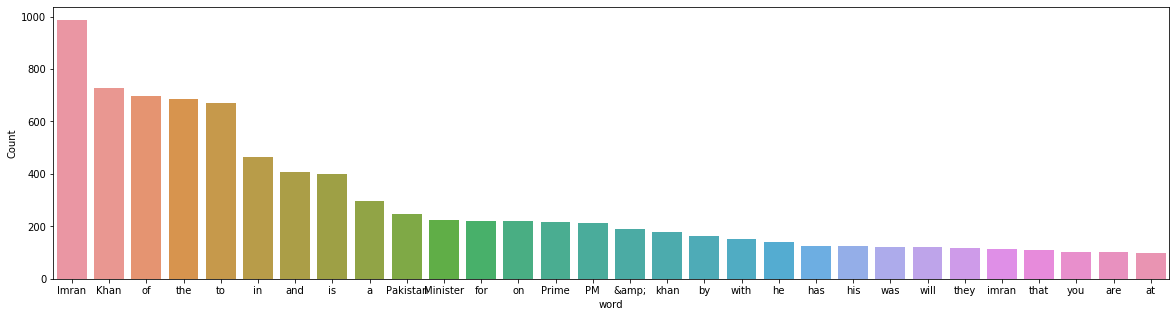

In [28]:
freq_words(df_tweets['cleaned'])

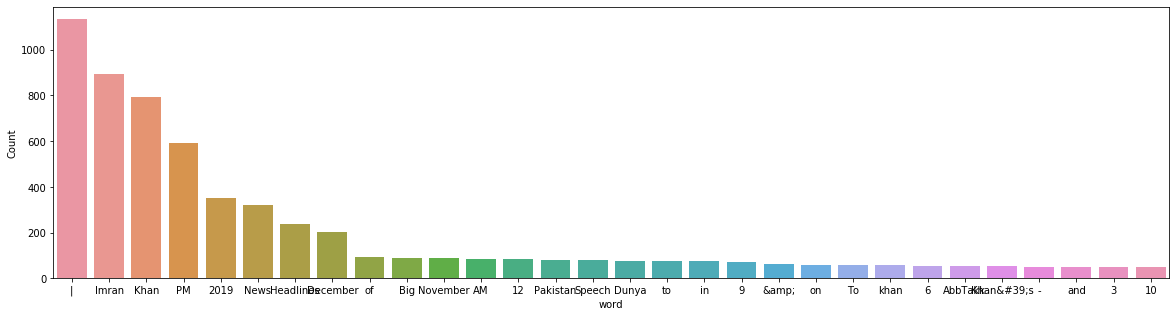

In [29]:
freq_words(df_videos['Title'])

In [33]:
# remove unwanted characters, numbers and symbols

df_tweets['cleaned'] = df_tweets['cleaned'].str.replace("[^a-zA-Z]", " ")
df_tweets['cleaned'] = df_tweets['cleaned'].str.replace('amp', " ")

df_videos['cleaned'] = df_videos['cleaned'].str.replace("[^a-zA-Z]", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("SAMAA TV", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("BBC", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("Dunya", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("News", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("Headlines", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("amp", " ")

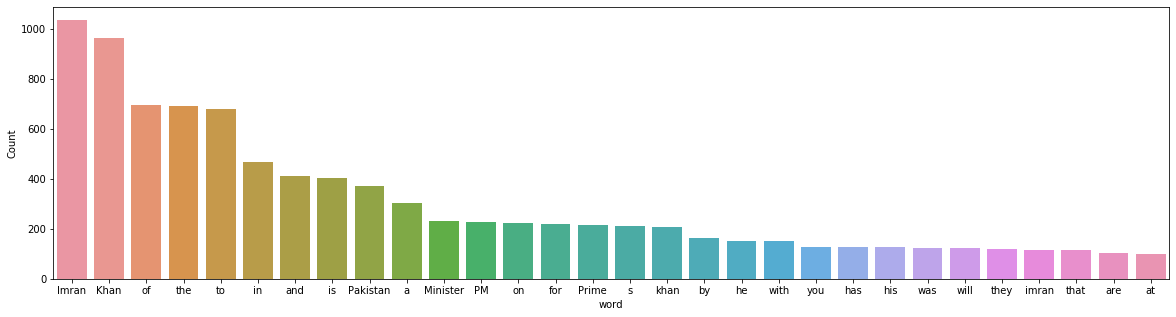

In [34]:
freq_words(df_tweets['cleaned'])

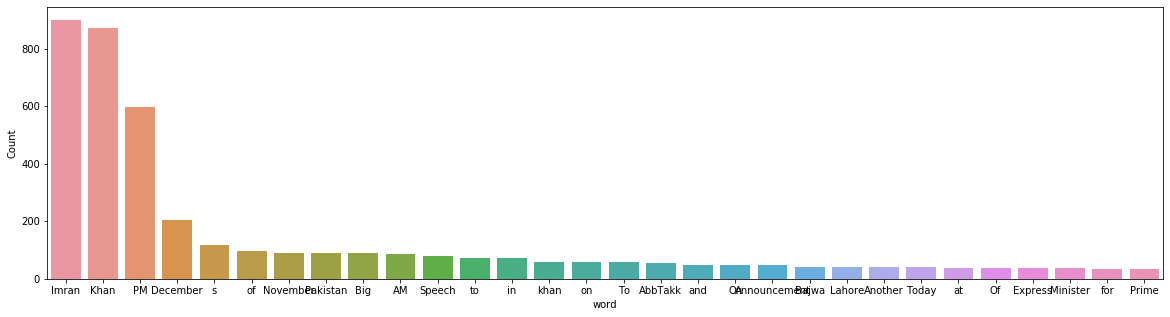

In [35]:
freq_words(df_videos['cleaned'])

# Text Preprocessing

In [36]:
stop_words = stopwords.words('english')

In [37]:
# function to remove stopwords

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [38]:
# remove short words (length < 3)

df_tweets['cleaned'] = df_tweets['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

df_videos['cleaned'] = df_videos['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [39]:
# remove stopwords from the text

tweets = [remove_stopwords(r.split()) for r in df_tweets['cleaned']]

videos = [remove_stopwords(r.split()) for r in df_videos['cleaned']]

In [40]:
# Convert letters into lower case

tweets = [r.lower() for r in tweets]

videos = [r.lower() for r in videos]

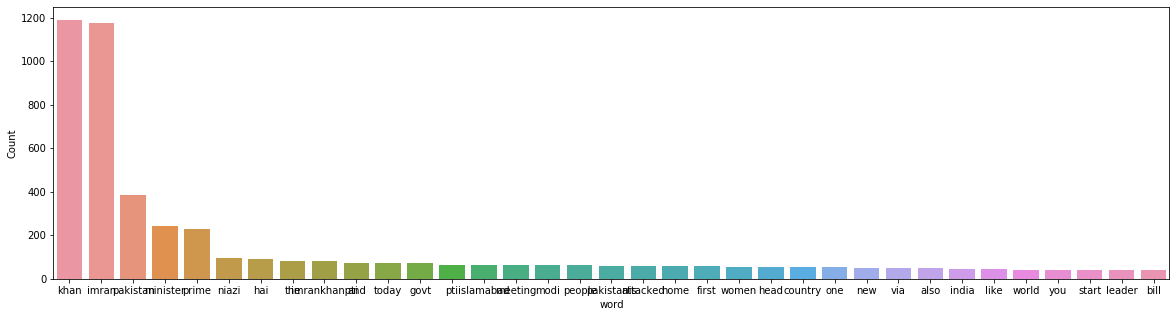

In [41]:
freq_words(tweets, 35)

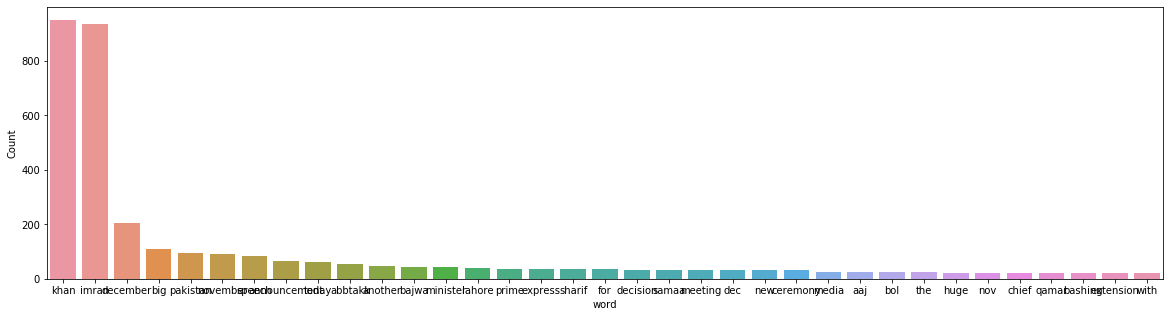

In [42]:
freq_words(videos, 35)

#Lemmatization
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [43]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        result.append(lemmatize_stemming(token))            
    return result

In [44]:
# Temporary dataframe for mapping lemmatized texts

tweets_1 = pd.DataFrame(tweets, columns=['text'])

videos_1 = pd.DataFrame(videos, columns=['title'])

In [45]:
# Extracting lemmatized words

processed_tweets = tweets_1['text'].map(preprocess)

processed_videos = videos_1['title'].map(preprocess)

In [46]:
processed_tweets.head()

0                                                                                                                                     [imran, khan, list, five, strategi, cope, smog, punjab, part, countri]
1                  [gulbukhari, dont, understand, countri, suffer, sever, year, corrupt, polit, instead, someth, good, countri, peopl, tweet, make, fun, that, realli, shame, see, peopl, love, imran, khan]
2                                [prime, minist, urg, world, help, end, curfew, there, curfew, imran, khan, check, basic, fact, speak, alway, spread, misinform, one, take, serious, joke, materi, pakistan]
3    [oye, kashmir, per, trend, kern, walon, oye, imran, khan, himayat, mai, awaz, uthani, walon, oyee, nawaz, sharif, himayat, mai, awaz, uthani, walon, oyee, khali, peeli, mai, number, barhani, walon...
4                              [inzi, world, cup, final, first, time, see, mani, peopl, stadium, imran, khan, realis, look, worri, say, start, fear, defeat, fail, worri, perform, f

In [47]:
processed_videos.head()

0      [norway, waqia, islamophobia, aik, taza, misaal, hey, imran, khan]
1    [imran, khan, aaj, pti, core, committe, ijla, aaj, talib, kar, liya]
2               [imran, khan, chair, pti, core, committe, session, today]
3                                       [imran, khan, make, big, announc]
4                   [imran, khan, announc, anoth, mission, novemb, samaa]
Name: title, dtype: object

In [48]:
# For tokenizing words from tweets

tokenized_tweets = []
for tweet in processed_tweets:
    tokenized_tweets.append(tweet)

tokenized_tweets[0]

['imran',
 'khan',
 'list',
 'five',
 'strategi',
 'cope',
 'smog',
 'punjab',
 'part',
 'countri']

In [49]:
# For tokenizing words from videos

tokenized_videos = []
for video in processed_videos:
    tokenized_videos.append(video)
    
tokenized_videos[0]

['norway',
 'waqia',
 'islamophobia',
 'aik',
 'taza',
 'misaal',
 'hey',
 'imran',
 'khan']

# Training an LDA

In [50]:
# We will start by creating the term dictionary of our corpus, where every unique term is assigned an index

dictionary = corpora.Dictionary(tokenized_tweets)

In [51]:
# Then we will convert the list of texts into a Document Term Matrix using the dictionary prepared above.

doc_term_matrix = [dictionary.doc2bow(text) for text in tokenized_tweets]

In [64]:
LDA = gensim.models.ldamodel.LdaModel

In [65]:
# Training the model on 10 topics
# Note: This may take a while...

num_topics = 15

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=100,
                chunksize=1000, passes=50)

In [66]:
# Save a pre-trained model to disk.

lda_model.save('model/lda_model_' + keyword + '_' + str(num_topics) + '_topics')

In [67]:
# Weights of words assigned to each topic by the model

lda_model.print_topics()

[(0,
  '0.081*"home" + 0.028*"imran" + 0.027*"khan" + 0.021*"arabia" + 0.021*"govern" + 0.020*"saudi" + 0.020*"pakistan" + 0.018*"establish" + 0.018*"pakistani" + 0.017*"program"'),
 (1,
  '0.039*"head" + 0.029*"govt" + 0.026*"imran" + 0.026*"program" + 0.025*"khan" + 0.022*"women" + 0.015*"former" + 0.015*"digit" + 0.015*"pakistan" + 0.013*"two"'),
 (2,
  '0.057*"khan" + 0.053*"imran" + 0.023*"hai" + 0.017*"pakistan" + 0.014*"discrimin" + 0.012*"the" + 0.010*"modi" + 0.010*"muslim" + 0.010*"anoth" + 0.009*"via"'),
 (3,
  '0.034*"bajwa" + 0.032*"ahmad" + 0.018*"chief" + 0.017*"across" + 0.017*"term" + 0.013*"khan" + 0.011*"month" + 0.010*"iqbal" + 0.010*"kashmir" + 0.010*"musharraf"'),
 (4,
  '0.057*"attack" + 0.028*"khan" + 0.028*"imran" + 0.022*"and" + 0.018*"then" + 0.018*"bushra" + 0.018*"faggot" + 0.014*"first" + 0.013*"sindh" + 0.013*"jemima"'),
 (5,
  '0.045*"imran" + 0.043*"khan" + 0.028*"hafeez" + 0.027*"ullah" + 0.015*"member" + 0.015*"call" + 0.014*"amshahidlatif" + 0.013*"t

In [68]:
# Visualize the topics
# Note: This WILL take a while... Again, ignore the warning

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

D:\AnacondaIDE\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [69]:
pyLDAvis.display(vis)

In [89]:
# Load a potentially pretrained model from disk.

# lda_model = LDA.load('model/lda_model_' + keyword + '_'+ str(num_topics) + '_topics')

In [70]:
# Now, need to assign topic to each tweet & video
# Note: This may take some time.. Also, ignore the warning

# For tweets:

corpus = [dictionary.doc2bow(text) for text in tokenized_tweets]
for i in range(0, len(df_tweets)):
    
    doc = corpus[i]
    
    # This contains probability of tweet assigned to each topic
    vector = lda_model[doc]
    
    # Getting the topic that has maximum probability
    max_res = 0
    
    for res in vector:
        if (res[1] > max_res):
            max_res = res[1]
            ind = res[0]
            
    df_tweets['Topic'][i] = np.int32(ind)
    
# For videos:

corpus = [dictionary.doc2bow(text) for text in tokenized_videos]
for i in range(0, len(df_videos)):
    
    doc = corpus[i]
    
    # This contains probability of video assigned to each topic
    vector = lda_model[doc]
    
    # Getting the topic that has maximum probability
    max_res = 0
    
    for res in vector:
        if (res[1] > max_res):
            max_res = res[1]
            ind = res[0]
    
    df_videos['Topic'][i] = np.int32(ind)

In [71]:
df_tweets.head()

,Created_time,URL,User_name,Twitter_handle,Description,Retweet_count,Favorite_count,Sentiment,Topic,cleaned
0,Sat Nov 30 23:52:15 +0000 2019,twitter.com/i/web/status/1200925541228064770,kami Khan,saleemkamikhan,PM Imran Khan lists down five strategies to cope with smog in Punjab and other parts of the country.\n\n#DunyaUpdates #DunyaNews #DunyaVideos https://t.co/tQNPcxIVJm,14,0,#ff0000,13,Imran Khan lists down five strategies cope with smog Punjab and other parts the country
1,Sat Nov 30 23:52:03 +0000 2019,twitter.com/i/web/status/1200925489742974976,Irfan Ullah,IrfanUK11,@GulBukhari I just dont understand country was suffering several years because of corrupt politics instead of doing something good for country and people you tweeting and making fun thats really s...,0,1,#8caa0b,10,GulBukhari just dont understand country was suffering several years because corrupt politics instead doing something good for country and people you tweeting and making fun thats really shame can ...
2,Sat Nov 30 23:51:07 +0000 2019,twitter.com/i/web/status/1200925253095972864,Sandy67,Sandy6704253501,#Pakistan Prime Minister #ImranKhan has urged the world to help end curfew in #Kashmir.\n\nThere is no curfew in #Kashmir. Imran Khan should check basic facts before speaking. He always spreads mi...,53,0,#8caa0b,2,Prime Minister has urged the world help end curfew There curfew Imran Khan should check basic facts before speaking always spreads misinformation that why one takes him seriously joke material Pak...
3,Sat Nov 30 23:50:01 +0000 2019,twitter.com/i/web/status/1200924976511094786,Syyed Farrukh,FarrukhSyyed,Oyee kashmir per trend kerne walon \nOyee imran Khan ki himayat mai awaz uthany walon \nOyeee nawaz sharif ki himayat mai Awaz uthany walon \nOyeee khali peeli mai number barhany walon \nKuch hosh...,0,0,#ff0000,4,Oyee kashmir per trend kerne walon Oyee imran Khan himayat mai awaz uthany walon Oyeee nawaz sharif himayat mai Awaz uthany walon Oyeee khali peeli mai number barhany walon Kuch hosh nakhun Masoom...
4,Sat Nov 30 23:47:43 +0000 2019,twitter.com/i/web/status/1200924400008257536,Nizam Sabahuddin,Zeemoo316,"Inzi ""In the 1992 World Cup final this was the first time I'd seen so many people in a stadium. Imran Khan realised I looked worried &amp; said, if you start fearing defeat you'll fail, if you wor...",105,0,#b3b3b3,10,Inzi the World Cup final this was the first time seen many people stadium Imran Khan realised looked worried said you start fearing defeat you fail you worry about how you perform front all these ...


In [72]:
df_tweets.groupby('Topic').count()

,Created_time,URL,User_name,Twitter_handle,Description,Retweet_count,Favorite_count,Sentiment,cleaned
Topic,,,,,,,,,
0,64,64,64,64,64,64,64,64,64
1,48,48,48,48,48,48,48,48,48
2,149,149,149,149,149,149,149,149,149
3,8,8,8,8,8,8,8,8,8
4,63,63,63,63,63,63,63,63,63
5,57,57,57,57,57,57,57,57,57
6,91,91,91,91,91,91,91,91,91
7,87,87,87,87,87,87,87,87,87
8,43,43,43,43,43,43,43,43,43


In [73]:
df_videos.head()

,Published_date,Title,URL,Channel_id,Topic,cleaned
0,2019-11-24,Norway Ka Waqia Islamophobia Ki Aik Taza Misaal Hey: PM Imran Khan,https://www.youtube.com/watch?v=oUffbzy63DE,UC_vt34wimdCzdkrzVejwX9g,10,Norway Waqia Islamophobia Aik Taza Misaal Hey Imran Khan
1,2019-11-24,Pm Imran khan ne Aaj PTI Core Committee ijlas aaj talib kar liya,https://www.youtube.com/watch?v=8qRdFGilKA0,UC_vt34wimdCzdkrzVejwX9g,7,Imran khan Aaj PTI Core Committee ijlas aaj talib kar liya
2,2019-11-24,PM Imran Khan to chair PTI core committee session today,https://www.youtube.com/watch?v=fDhy5S0zfgA,UCMmpLL2ucRHAXbNHiCPyIyg,11,Imran Khan chair PTI core committee session today
3,2019-11-24,Imran Khan makes Big Announcements,https://www.youtube.com/watch?v=XX47tVdjVIs,UCu5HXdNKsmWpfz5zeRCPXog,1,Imran Khan makes Big Announcements
4,2019-11-24,PM Imran Khan announced his another mission | Headlines 10 AM | 24 November 2019 | Samaa News,https://www.youtube.com/watch?v=WMRBu6I8bbc,UC25Ntv5IrTD-B0eZ92O50Tg,11,Imran Khan announced his another mission November Samaa


In [74]:
df_videos.groupby('Topic').count()

,Published_date,Title,URL,Channel_id,cleaned
Topic,,,,,
0,19,19,19,19,19
1,17,17,17,17,17
2,96,96,96,96,96
3,14,14,14,14,14
4,21,21,21,21,21
5,38,38,38,38,38
6,32,32,32,32,32
7,54,54,54,54,54
8,32,32,32,32,32


In [75]:
# Drop the temporary columns

df_tweets = df_tweets.drop(['cleaned'], axis=1)
df_videos = df_videos.drop(['cleaned'], axis=1)

In [76]:
# Export twitter data to json format for further processing

df_tweets.to_json(r'model\topic-tweets_' + keyword + '_' + str(num_topics) + '_topics.json')

In [77]:
# Export youtube data to json format for further processing

df_videos.to_json(r'model\topic-videos_' + keyword + '_' + str(num_topics) + '_topics.json')